# Applying a *logistic* regression to NFL field goal data

### 0. Import required modules

In [552]:
import pandas as pd #import pandas library for data manipulation (https://pandas.pydata.org/)
import numpy as np #import the 'NumPy' module for scientific computing with Python (https://numpy.org/)
import plotly.express as px
import statistics as st
import math

In [553]:
%run -i 'SportsAnalytics.py' #source required functions for building a logistic regression and plotting the results

### 1. Read data as pandas dataframe
*see [1. Reading in files using pandas (.csv, .xls, .json)](01_read_files.ipynb)*

In [554]:
#--- read in 'raw_data' sheet from 'nfl_field_goal_sol.xlsx' file using pandas read_excel function
fg_df = pd.read_excel('nfl_field_goal_sol.xlsx', sheet_name = 'raw_data')
fg_df.head() #display the head (first 5 rows) of field_goal_df

,gid,pid,fgxp,dist,make,season,postseason,away,stadium,temp,humidity,wind-spd,cond,surface,player id,player
0,3189,518667,FG,33,1,2012,0,1,MetLife Stadium,77,63,5,Fair,FieldTurf,DB-0200,Dan Bailey
1,3190,518780,FG,35,1,2012,0,0,Soldier Field,67,66,13,Partly Cloudy,Grass,RG-1500,Robbie Gould
2,3190,518806,FG,37,0,2012,0,1,Soldier Field,67,66,13,Partly Cloudy,Grass,AV-0400,Adam Vinatieri
3,3190,518822,FG,26,1,2012,0,0,Soldier Field,67,66,13,Partly Cloudy,Grass,RG-1500,Robbie Gould
4,3191,518902,FG,43,1,2012,0,0,Cleveland Browns Stadium,68,57,9,Sunny,Grass,PD-0200,Phil Dawson


### 2. Split data into train and test dataframes
*see section 5 in [3. Manipulating pandas dataframes](03_manipulate_data.ipynb)*

In [555]:
#--- subset data into train and test dataframes by season < 2016
fg_train_df = fg_df[fg_df['season'] < 2016]
fg_test_df = fg_df[fg_df['season'] >= 2016]

### 3. Fitting a logistic regression
*see [4. Modelling data using logistic regression](04_logistic_regression.ipynb)*

In [556]:
#--- Use the LogisticRegTrain() function from 'SportsAnalytics.py' to build a logistic regression model
model = LogisticRegTrain(X = fg_train_df['dist'], Y = fg_train_df['make'])

Optimization terminated successfully.
         Current function value: 0.349091
         Iterations 7
                      const    dist
make                               
Coefficients         6.3299 -0.1085
Std error            0.2947  0.0065
p-value              0.0000  0.0000
Log-likelihood   -1125.4691        
Number valid obs  3222.0000        
Total obs         3224.0000        


In [557]:
#--- Find the min and max values of x
min_x = min(fg_train_df['dist'])
max_x = max(fg_train_df['dist'])

#--- Use the Binned_stats() function from 'SportsAnalytics.py' to aggregate y for buckets/bins of x
binned_stats = Binned_stats(
    buckets = range(min_x, max_x), 
    col1 = fg_train_df['dist'], 
    col2 = fg_train_df['make'])

binned_stats.head()

,Bins,Count,Avg dist,Avg make,Stderr make
0,"[18,19)",6,18.00,1.00,0.00
1,"[19,20)",37,19.00,1.00,0.00
2,"[20,21)",81,20.00,1.00,0.00
3,"[21,22)",66,21.00,1.00,0.00
4,"[22,23)",82,22.00,0.99,0.02


### 4. Plotting the logistic regression

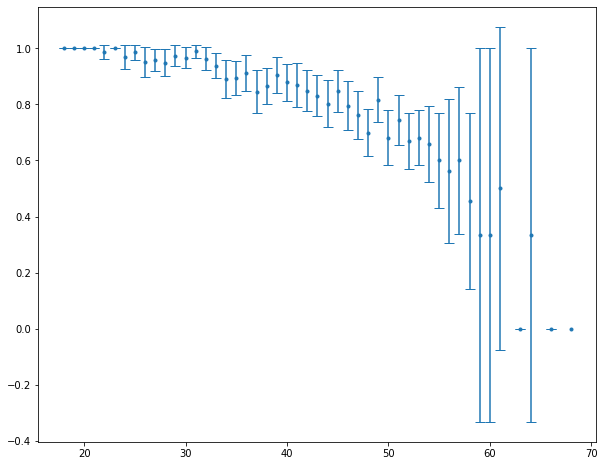

In [558]:
#--- Use the Graph_Binned_stats() function from 'SportsAnalytics.py' to plot binned stats
Graph_Binned_stats(binned_stats)

In [559]:
#--- Use the LogisticRegPredict() function from 'SportsAnalytics.py' to predict values of y with known values of x
model_predict = LogisticRegPredict(model, X = range(min_x, max_x))
model_predict.tail()

,dist,prediction
48,66.00,0.30
49,67.00,0.28
50,68.00,0.26
51,69.00,0.24
52,70.00,0.22


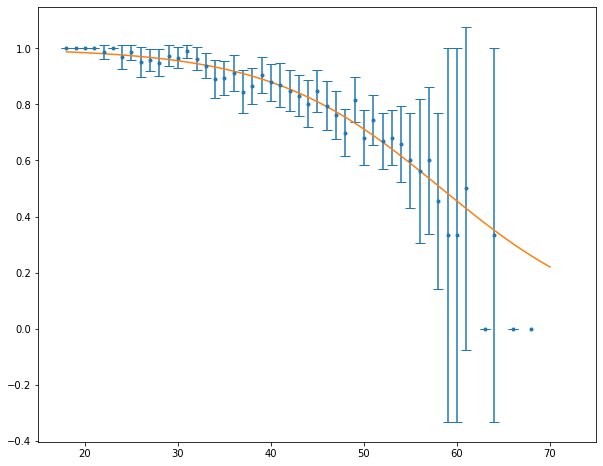

In [560]:
#--- Use the Graph_Binned_stats_with_prediction() function from 'SportsAnalytics.py' to plot binned stats with an overlay of the logistic model
Graph_Binned_stats_with_prediction(
    binned_stats, 
    lineX = model_predict['dist'], 
    lineY = model_predict['prediction'], 
    linestyle = 1,
    xlims = [15, 75])

### 5. Model validation with test dataset

In [561]:
#--- create df for continuous logit predictions 
fg_test_cont_logit_predict_df = pd.merge(
    fg_test_df, 
    model_predict.rename(columns={'prediction':'make-prediction'}), 
    on='dist')
fg_test_cont_logit_predict_df['model'] = 'cont-logit'

In [562]:
#--- create df for discrete logit predictions 
fg_test_disc_logit_predict_df = fg_test_cont_logit_predict_df.copy()
fg_test_disc_logit_predict_df['make-prediction'] = np.where(
    fg_test_disc_logit_predict_df['make-prediction']<0.5, 0, 1)
fg_test_disc_logit_predict_df['model'] = 'disc-logit'

In [563]:
#--- create df for continuous random predictions
random.seed(10)
fg_test_cont_rand_predict_df = fg_test_df.copy()
fg_test_cont_rand_predict_df['make-prediction'] = np.random.uniform(
    0, 1, size = len(fg_test_cont_rand_predict_df.index))
fg_test_cont_rand_predict_df['model'] = 'cont-rand'

In [564]:
#--- create df for discrete random predictions
random.seed(10)
fg_test_disc_rand_predict_df = fg_test_df.copy()
fg_test_disc_rand_predict_df['make-prediction'] = np.random.choice(
    [0, 1], len(fg_test_disc_rand_predict_df.index), p=[0.5, 0.5])
fg_test_disc_rand_predict_df['model'] = 'disc-rand'

In [565]:
#--- create df for mean average predictions
fg_test_avg_predict_df = fg_test_df.copy()
fg_test_avg_predict_df['make-prediction'] = st.mean(fg_train_df['make'])
fg_test_avg_predict_df['model'] = 'avg'

In [566]:
#--- bind the 5 varied model predictions togteher 
all_models = pd.concat([fg_test_cont_logit_predict_df, 
                       fg_test_disc_logit_predict_df,
                       fg_test_cont_rand_predict_df,
                       fg_test_disc_rand_predict_df,
                       fg_test_avg_predict_df])

#create erorr variable for each prediction (actual-prediction)
all_models['error'] = all_models['make']-all_models['make-prediction']

In [567]:
#--- create functions for MAE, MSE and RMSE validation metrics
def mae(x):
    res = abs(x).mean() 
    return res

def mse(x):
    res = np.square(x).mean() 
    return res
    
def rmse(x):
    res = math.sqrt(np.square(x).mean())
    return res

def mean_perc(x):
    res = x.mean()*100
    return res

In [568]:
#--- apply model validation functions to each model 
model_results = (
    all_models.groupby(['model'], as_index=False)
    .agg(
        # Get mean erorr for each model type
        me = pd.NamedAgg(column = 'error', aggfunc = 'mean'),
        # Get mean abs erorr for each model type
        mae = pd.NamedAgg(column = 'error', aggfunc = mae),
        # Get mean square erorr for each model type
        mse = pd.NamedAgg(column = 'error', aggfunc = mse),
        # Get mean square erorr for each model type
        rmse = pd.NamedAgg(column = 'error', aggfunc = rmse)
    )
    .sort_values('rmse', ascending=True))

model_results

,model,me,mae,mse,rmse
1,cont-logit,-0.00,0.21,0.11,0.33
0,avg,-0.00,0.25,0.12,0.35
3,disc-logit,-0.14,0.14,0.14,0.38
2,cont-rand,0.37,0.50,0.33,0.58
4,disc-rand,0.34,0.48,0.48,0.69


#### Results of model validation...  
This result tells us that the logistic model continuous predictions have an average absolute erorr of 21% from the actual results.  
This is 4% better than always assuming the average make % of a field goal (~86%) and ~30% better than having both continuous and discrete random predictions for each field goal attempt.  
Interestingly, the discrete predictions from the logistic model have a lower mean-absolute-error (mae) at 14%, but a higher root-mean-square-error at 38%.  
This provides us with the validation we need to move forward with applying the logistic regression to the original dataset. 

### 6. Apply logistic regression to orginal dataset 
*see section 4 in [3. Manipulating pandas dataframes](03_manipulate_data.ipynb)*

In [569]:
#--- apply logistic regression continuous predictions to original df 'fg_df'
fg_predict_df = fg_df.merge(model_predict.rename(columns={'prediction':'make-prediction'}), on='dist')
fg_predict_df['make-vs-prediction'] = fg_predict_df['make']-fg_predict_df['make-prediction']
fg_predict_df.head()

,gid,pid,fgxp,dist,make,season,postseason,away,stadium,temp,humidity,wind-spd,cond,surface,player id,player,make-prediction,make-vs-prediction
0,3189,518667,FG,33,1,2012,0,1,MetLife Stadium,77,63,5,Fair,FieldTurf,DB-0200,Dan Bailey,0.94,0.06
1,3207,521630,FG,33,1,2012,0,1,Ralph Wilson Stadium,66,55,11,Mostly Sunny,A Turf Titan,RS-3400,Ryan Succop,0.94,0.06
2,3214,522794,FG,33,1,2012,0,0,Edward Jones Dome,-999,-999,-999,Dome,AstroTurf,GZ-2000,Greg Zuerlein,0.94,0.06
3,3226,524757,FG,33,1,2012,0,1,Sun Life Stadium,83,76,4,Mostly Cloudy,Grass,NF-0300,Nick Folk,0.94,0.06
4,3226,524888,FG,33,1,2012,0,1,Sun Life Stadium,83,76,4,Mostly Cloudy,Grass,NF-0300,Nick Folk,0.94,0.06


In [570]:
fg_predict_df.to_excel('field_goal_predict_df.xlsx') #write field goal dataframe with logit predictions to excel file

### 7. Aggregate results of logistic regression predictions

In this section we are going to take the application of the logisitic regression model and use it to answer a number of questions...  
1. Who are the best and worst kickers? 
2. Which kicker has had the most successful season?
3. Which stadium is the toughest to kick a field goal in? 
4. Which surfaces are the easiest and toughest to kick a field goal on?
5. Does home advantage exist for kicking field goals?  

*see section 9 in [3. Manipulating pandas dataframes](03_manipulate_data.ipynb)*

In [571]:
#--- aggregate the data to calculate each kicker's expected field goals vs. actual for all seasons

total_player_fg_success = (
    fg_predict_df.groupby(['player', 'player id'], as_index=False)
    .agg(
        # Get the number of field goal attempts
        total_fg = pd.NamedAgg(column = 'make-vs-prediction', aggfunc = 'count'),
        # Get the predicted number of successful attempts
        predicted_successful_fg = pd.NamedAgg(column = 'make-prediction', aggfunc = 'sum'),
        # Get the actual number of successful kicks
        successful_fg = pd.NamedAgg(column = 'make', aggfunc = 'sum'),
        # Get the difference between actual and predicted success
        vs_prediction_fg = pd.NamedAgg(column = 'make-vs-prediction', aggfunc = 'sum'))
    .sort_values('vs_prediction_fg', ascending=False))

total_player_fg_success.head()

,player,player id,total_fg,predicted_successful_fg,successful_fg,vs_prediction_fg
17,Justin Tucker,JT-3950,195,164.07,176,11.93
9,Dan Bailey,DB-0200,160,135.14,143,7.86
30,Stephen Gostkowski,SG-0800,198,172.33,179,6.67
0,Adam Vinatieri,AV-0400,176,149.16,154,4.84
31,Steven Hauschka,SH-0400,187,164.76,169,4.24


In [572]:
#--- aggregate the data to calculate each kicker's expected field goal % vs. actual % for all seasons

avg_player_fg_success = (
    fg_predict_df.groupby(['player', 'player id'], as_index=False)
    .agg(
        # Get the number of field goal attempts
        total_fg = pd.NamedAgg(column = 'make-vs-prediction', aggfunc = 'count'),
        # Get the predicted number of successful attempts
        avg_predicted_successful_fg = pd.NamedAgg(column = 'make-prediction', aggfunc = mean_perc),
        # Get the actual number of successful kicks
        avg_successful_fg = pd.NamedAgg(column = 'make', aggfunc = mean_perc),
        # Get the difference between actual and predicted success
        avg_vs_prediction_fg = pd.NamedAgg(column = 'make-vs-prediction', aggfunc = mean_perc))
    .sort_values('avg_vs_prediction_fg', ascending=False))

In [573]:
avg_player_fg_success.head() #show the 5 best kickers according to actual vs predicted % kick success

,player,player id,total_fg,avg_predicted_successful_fg,avg_successful_fg,avg_vs_prediction_fg
17,Justin Tucker,JT-3950,195,84.14,90.26,6.12
9,Dan Bailey,DB-0200,160,84.47,89.38,4.91
15,Josh Brown,JB-7100,110,88.00,91.82,3.82
30,Stephen Gostkowski,SG-0800,198,87.04,90.40,3.37
6,Chris Boswell,CB-2275,72,87.13,90.28,3.15


#### Justin Tucker has the highest relative kick success rate at +6.12%.  
This means that he has kicked 6.12% more field goals than expected (given the distance of each kick).

In [574]:
avg_player_fg_success.tail() #show the 5 worst kickers according to actual vs predicted % kick success

,player,player id,total_fg,avg_predicted_successful_fg,avg_successful_fg,avg_vs_prediction_fg
7,Cody Parkey,CP-0575,65,88.41,84.62,-3.79
16,Josh Lambo,JL-0207,64,85.89,81.25,-4.64
22,Mike Nugent,MN-0800,138,86.24,81.16,-5.08
26,Randy Bullock,RB-4650,102,86.69,81.37,-5.32
4,Caleb Sturgis,CS-4250,134,86.24,80.60,-5.64


#### Caleb Sturgis has the lowest relative kick success rate at -5.64%.  
This means that he has kicked 5.64% less field goals than expected (given the distance of each kick).

In [575]:
#--- aggregate the data to calculate each kicker's expected field goal % vs. actual % for each season

avg_player_season_fg_success = (
    fg_predict_df.groupby(['player', 'player id', 'season'], as_index=False)
    .agg(
        # Get the number of field goal attempts
        total_fg = pd.NamedAgg(column = 'make-vs-prediction', aggfunc = 'count'),
        # Get the predicted number of successful attempts
        avg_predicted_successful_fg = pd.NamedAgg(column = 'make-prediction', aggfunc = mean_perc),
        # Get the actual number of successful kicks
        avg_successful_fg = pd.NamedAgg(column = 'make', aggfunc = mean_perc),
        # Get the difference between actual and predicted success
        avg_vs_prediction_fg = pd.NamedAgg(column = 'make-vs-prediction', aggfunc = mean_perc))
    .sort_values('avg_vs_prediction_fg', ascending=False)
    .query("`total_fg` >= 20"))

avg_player_season_fg_success.head()

,player,player id,season,total_fg,avg_predicted_successful_fg,avg_successful_fg,avg_vs_prediction_fg
67,Justin Tucker,JT-3950,2016,39,81.73,97.44,15.71
84,Matt Prater,MP-2100,2013,32,82.66,93.75,11.09
33,Dan Bailey,DB-0200,2013,30,83.60,93.33,9.73
86,Matt Prater,MP-2100,2015,24,83.12,91.67,8.55
5,Blair Walsh,BW-0350,2012,39,84.10,92.31,8.21


#### Justin Tucker had the most successful season of any kicker in 2016, with a relative success rate of +15.71%.  
This means that during the 2016 season he kicked 15.71% more field goals than expected (given the distance of each kick).

In [576]:
#--- aggregate the data to calculate each stadiums's expected field goal % vs. actual % for all seasons

#read in stadium matching dataframe to remove spelling errors
df_stadium = pd.read_excel('stadium_df.xlsx', index_col=0)

stadium_fg_success = (
    fg_predict_df.merge(df_stadium, on = 'stadium').groupby(['stadium-name'], as_index=False)
    .agg(
        # Get the number of field goal attempts
        total_fg = pd.NamedAgg(column = 'make-vs-prediction', aggfunc = 'count'),
        # Get the predicted number of successful attempts
        avg_predicted_successful_fg = pd.NamedAgg(column = 'make-prediction', aggfunc = mean_perc),
        # Get the actual number of successful kicks
        avg_successful_fg = pd.NamedAgg(column = 'make', aggfunc = mean_perc),
        # Get the difference between actual and predicted success
        avg_vs_prediction_fg = pd.NamedAgg(column = 'make-vs-prediction', aggfunc = mean_perc))
    .sort_values('avg_vs_prediction_fg', ascending=False)
    .query("`total_fg` >= 50")) # remove stadiums that have a low sample-size of field goal attempts (< 50)

In [577]:
stadium_fg_success.head()

,stadium-name,total_fg,avg_predicted_successful_fg,avg_successful_fg,avg_vs_prediction_fg
8,EverBank Field,97,84.68,88.66,3.98
7,Edward Jones Dome,105,82.89,86.67,3.77
12,Georgia Dome,142,85.77,89.44,3.66
36,TCF Bank Stadium,65,84.22,87.69,3.48
2,Bank of America Stadium,145,85.73,88.97,3.23


#### The EverBank Field has been the easiest stadium to kick field goals, with a relative success rate of +3.98%. 
This means that 3.98% more field goals have been kicked than expected (given the distance of each kick).

In [578]:
stadium_fg_success.tail()

,stadium-name,total_fg,avg_predicted_successful_fg,avg_successful_fg,avg_vs_prediction_fg
1,Arrowhead Stadium,150,86.44,82.67,-3.77
33,Soldier Field,127,86.90,81.89,-5.01
26,Oakland-Alameda County Coliseum,143,84.82,79.72,-5.09
39,University of Phoenix Stadium,111,86.25,81.08,-5.17
35,SunLife Stadium,134,85.92,77.61,-8.31


#### The SunLife Stadium has been the toughest stadium to kick field goals, with a relative success rate of -8.31%. 
This means that 8.31% less field goals have been kicked than expected (given the distance of each kick).

In [579]:
#--- visualise the field goal success rate by stadium (with 45 degree reference line)

fig = px.scatter(
    stadium_fg_success, 
    x="avg_predicted_successful_fg", y="avg_successful_fg", text="stadium-name", 
    log_x=False, size_max=100, color="total_fg")
fig.update_traces(textposition='top center')
fig.update_layout(title_text='Field Goal Success Rate by Stadium', title_x=0.5,
                 shapes = [{'type': 'line', 'yref': 'paper', 'xref': 'paper', 'y0': 0, 'y1': 100, 'x0': 0, 'x1': 100}],
                 yaxis_range=[77,92],
                 xaxis_range=[77,92])
fig.show()

In [580]:
#--- aggregate the data to calculate each field surfaces's expected field goal % vs. actual % for all seasons

surface_fg_success = (
    fg_predict_df.groupby(['surface'], as_index=False)
    .agg(
        # Get the number of field goal attempts
        total_fg = pd.NamedAgg(column = 'make-vs-prediction', aggfunc = 'count'),
        # Get the predicted number of successful attempts
        avg_predicted_successful_fg = pd.NamedAgg(column = 'make-prediction', aggfunc = mean_perc),
        # Get the actual number of successful kicks
        avg_successful_fg = pd.NamedAgg(column = 'make', aggfunc = mean_perc),
        # Get the difference between actual and predicted success
        avg_vs_prediction_fg = pd.NamedAgg(column = 'make-vs-prediction', aggfunc = mean_perc))
    .sort_values('avg_vs_prediction_fg', ascending=False)
    .query("`total_fg` >= 100")) # remove field surfaces that have a low sample-size of field goal attempts (< 100)

surface_fg_success

,surface,total_fg,avg_predicted_successful_fg,avg_successful_fg,avg_vs_prediction_fg
2,AstroTurf,506,84.64,88.14,3.50
4,FieldTurf,712,85.90,87.64,1.74
7,UBU Speed Series S5M,445,86.70,87.42,0.72
5,Grass,2087,85.97,84.76,-1.21
6,MomentumTurf,130,85.53,83.08,-2.46
0,A Turf Titan,122,86.99,84.43,-2.56
3,DD GrassMaster,178,86.60,83.15,-3.45


#### 'AstroTurf' has been the easiest surface to kick field goals, with a relative success rate of +3.5%. 
This means that 3.5% more field goals have been kicked than expected (given the distance of each kick).

#### 'DD GrassMaster' has been the toughest surface to kick field goals, with a relative success rate of -3.45%. 
This means that 3.45% less field goals have been kicked than expected (given the distance of each kick).

In [582]:
#--- aggregate the data to calculate the expected field goal % vs. actual % for the home-team and away-team

home_advantage_fg_success = (
    fg_predict_df.groupby(['away'], as_index=False)
    .agg(
        # Get the number of field goal attempts
        total_fg = pd.NamedAgg(column = 'make-vs-prediction', aggfunc = 'count'),
        # Get the predicted number of successful attempts
        avg_predicted_successful_fg = pd.NamedAgg(column = 'make-prediction', aggfunc = mean_perc),
        # Get the actual number of successful kicks
        avg_successful_fg = pd.NamedAgg(column = 'make', aggfunc = mean_perc),
        # Get the difference between actual and predicted success
        avg_vs_prediction_fg = pd.NamedAgg(column = 'make-vs-prediction', aggfunc = mean_perc))
    .sort_values('avg_vs_prediction_fg', ascending=False))

home_advantage_fg_success

,away,total_fg,avg_predicted_successful_fg,avg_successful_fg,avg_vs_prediction_fg
0,0,2125,86.17,86.40,0.23
1,1,2058,85.68,85.23,-0.45


#### The advantage of kicking a field goal in front of a home crowd is fairly minimal but does exist, with home-team kicks being 0.68% more successful than away-team kicks